# 🎯 Cart-Pole EoMs and Numerical Simulation

In this notebook, we present the full derivation of the **nonlinear equations of motion (EoMs)** of the cart-pole system using the **Lagrangian method**.

Then, we demonstrate how to simulate the system using the **explicit Euler method**, a simple but intuitive numerical solver. We'll also explain how we convert symbolic math to numerical functions using `sympy.lambdify`.


In [1]:
from sympy import symbols, Function, diff, simplify, lambdify, sin, cos, solve
from sympy.physics.mechanics import dynamicsymbols

# --- Define symbols ---
t = symbols('t')
x = Function('x')(t)
x_dot = diff(x, t)
theta = Function('theta')(t)
theta_dot = diff(theta, t)

m, M, l, g, F, cx, ctheta = symbols('m M l g F cx ctheta')

# --- Kinetic and Potential Energy ---
T_cart = (1/2)*M*x_dot**2
v_pendulum = x_dot + l * cos(theta) * theta_dot
w_pendulum = l * sin(theta) * theta_dot
T_pendulum = (1/2)*m * (v_pendulum**2 + w_pendulum**2)
T = simplify(T_cart + T_pendulum)

V = -m * g * l * cos(theta)
L = T - V

# --- Generalized Forces ---
Q_x = F - cx * x_dot
Q_theta = -ctheta * theta_dot

# --- Euler-Lagrange Equations ---
dL_dx = diff(L, x)
dL_dx_dot = diff(L, x_dot)
d_dt_dL_dx_dot = diff(dL_dx_dot, t)
EL_x = simplify(d_dt_dL_dx_dot - dL_dx - Q_x)

dL_dtheta = diff(L, theta)
dL_dtheta_dot = diff(L, theta_dot)
d_dt_dL_dtheta_dot = diff(dL_dtheta_dot, t)
EL_theta = simplify(d_dt_dL_dtheta_dot - dL_dtheta - Q_theta)

# --- Solve for accelerations ---
sol = simplify(solve([EL_x, EL_theta], (x.diff(t, t), theta.diff(t, t))))
x_ddot_expr = sol[x.diff(t, t)]
theta_ddot_expr = sol[theta.diff(t, t)]


## 🧠 From Symbolic to Numerical: Using `lambdify`

The expressions for $\ddot{x}$ and $\ddot{\theta}$ are symbolic.

To simulate numerically, we must convert them to **fast numerical functions**.
We use `sympy.lambdify` to turn symbolic expressions into Python callables:

```python
x_ddot_func = lambdify((x, x_dot, theta, theta_dot, F, m, M, l, g, cx, ctheta), x_ddot_expr)
```

This returns a function that behaves like:

```python
x_ddot_func(x_val, xdot_val, theta_val, thetadot_val, F, m, M, l, g, cx, ctheta)
```

It evaluates the symbolic formula numerically using NumPy.


## 🧮 Solver Overview

We aim to numerically integrate the nonlinear equations of motion:

$$
\begin{align}
\ddot{x} &= f(x, \dot{x}, \theta, \dot{\theta}) \\
\ddot{\theta} &= g(x, \dot{x}, \theta, \dot{\theta})
\end{align}
$$

These are **second-order differential equations**.  
To simulate the system, we rewrite them as a **first-order system** by introducing a state vector:

$$
\mathbf{y} =
\begin{bmatrix}
x \\
\dot{x} \\
\theta \\
\dot{\theta}
\end{bmatrix}
\quad \text{with} \quad
\frac{d\mathbf{y}}{dt} =
\begin{bmatrix}
\dot{x} \\
f(x, \dot{x}, \theta, \dot{\theta}) \\
\dot{\theta} \\
g(x, \dot{x}, \theta, \dot{\theta})
\end{bmatrix}
$$

---

### 🔄 Explicit Euler Method

The **explicit Euler method** is the simplest numerical integrator.  
At each step, it estimates the next state by **adding the derivative scaled by the time step**:

$$
\mathbf{y}_{n+1} = \mathbf{y}_n + \Delta t \cdot \frac{d\mathbf{y}_n}{dt}
$$

This is equivalent to a **discrete approximation of an integral**:

$$
\mathbf{y}(t + \Delta t) \approx \mathbf{y}(t) + \int_t^{t + \Delta t} \frac{d\mathbf{y}}{dt} \, dt
\approx \mathbf{y}(t) + \frac{d\mathbf{y}(t)}{dt} \cdot \Delta t
$$

The idea is to assume the derivative stays **constant** during the time step —  
this makes it simple, but not very accurate or stable for stiff or fast systems.

---

### 💡 Summary

Euler method is simple and intuitive:

- ✅ Easy to implement
- ❌ Not accurate for large time steps or unstable systems
- 🚀 Good starting point before trying better integrators (Runge-Kutta etc.)

We’ll use this method in a loop to simulate how the state evolves over time.



In [2]:
import numpy as np

# Lambdify symbolic expressions for acceleration to get fast numerical functions
x_ddot_func = lambdify((x, x_dot, theta, theta_dot, F, m, M, l, g, cx, ctheta), x_ddot_expr)
theta_ddot_func = lambdify((x, x_dot, theta, theta_dot, F, m, M, l, g, cx, ctheta), theta_ddot_expr)

# System parameters (mass of pendulum, cart, length, gravity, damping)
params = {
    'm': 0.1,      # pendulum mass [kg]
    'M': 1.0,      # cart mass [kg]
    'l': 1.0,      # pendulum length [m]
    'g': 9.81,     # gravity [m/s²]
    'cx': 0.1,     # cart damping coefficient
    'ctheta': 0.05 # pendulum damping coefficient
}

# Initial state: [position, velocity, angle, angular velocity]
state = np.array([0.0, 0.0, 0.2, 0.0])  # Small initial angle from vertical

# Simulation configuration
T_total = 10.0    # total simulation time [s]
dt = 0.01         # timestep [s]
N = int(T_total / dt)   # number of steps
time = np.linspace(0, T_total, N)  # time array for plotting

# Pre-allocate array to store the simulation history
history = np.zeros((N, 4))
history[0, :] = state  # store initial state

# Define external force input (can be customized to impulse or control later)
def external_force(t):
    return 0.0  # zero force = passive system

# --- Euler integration loop ---
for i in range(1, N):
    # Unpack current state
    x, x_dot, theta, theta_dot = state

    # Compute external force at current time step
    F_ext = external_force(time[i])

    # Compute accelerations using the symbolic functions
    dx2 = x_ddot_func(x, x_dot, theta, theta_dot, F_ext, **params)
    dtheta2 = theta_ddot_func(x, x_dot, theta, theta_dot, F_ext, **params)

    # Update velocities and positions using explicit Euler method
    x_dot += dx2 * dt
    x += x_dot * dt

    theta_dot += dtheta2 * dt
    theta += theta_dot * dt

    # Update the state and store it in history
    state = np.array([x, x_dot, theta, theta_dot])
    history[i, :] = state


## 📊 Plotting the Simulation Results

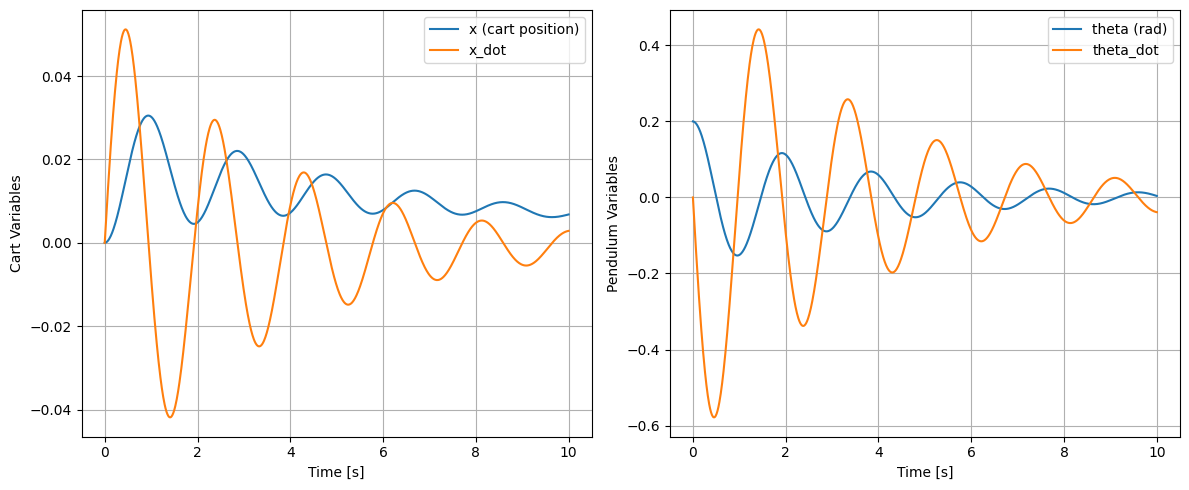

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time, history[:, 0], label='x (cart position)')
plt.plot(time, history[:, 1], label='x_dot')
plt.xlabel('Time [s]')
plt.ylabel('Cart Variables')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time, history[:, 2], label='theta (rad)')
plt.plot(time, history[:, 3], label='theta_dot')
plt.xlabel('Time [s]')
plt.ylabel('Pendulum Variables')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()